<a href="https://colab.research.google.com/github/pierretd/DS-Unit-2-Sprint-4-Model-Validation/blob/master/BikeAccidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Bike Accidents 


Tools

*   Pipelines
* Lasso
* Ridge
* Standard Scaler
* Elastic Net
* Random Forest Regressor
* Gradfient Forest Regressor
* Hyperparmeters
* GridsearchCV



In [0]:
#Credit to Ryan Herr for providing code

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## 1.Data Munging

In [0]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1536k    0 1536k    0     0   306k      0 --:--:--  0:00:05 --:--:--  385k


In [0]:
!wget https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv

--2019-01-30 20:29:09--  https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 234945 (229K) [text/plain]
Saving to: ‘BicycleWeather.csv.4’

BicycleWeather.csv. 100%[===================>] 229.44K  --.-KB/s    in 0.04s   

2019-01-30 20:29:09 (5.58 MB/s) - ‘BicycleWeather.csv.4’ saved [234945/234945]



### Create Counts, Weather, and Daily Totals

In [0]:
# Modified from cells 15, 16, and 20, at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic

counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True, 
                     infer_datetime_format=True)

weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True, 
                      infer_datetime_format=True)

daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
daily = daily.join(weather[weather_columns], how='inner')

# Make a feature for yesterday's total
daily['Total_yesterday'] = daily.Total.shift(1)

daily = daily.drop(index=daily.index[0])


In [0]:
target = daily.Total

inputs = daily.drop('Total', axis=1)

In [0]:
target.head(1)

2012-10-04    3475.0
Name: Total, dtype: float64

In [0]:
inputs.head(1)

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-10-04,0,0,0,189,83,65,3521.0


In [0]:
from sklearn.model_selection import train_test_split
results = train_test_split(
        inputs,
        target, 
        test_size = 0.2,
        random_state = 42
)

In [0]:
print(type(results))
print(len(results))
print('---')
for item in results:
    print(item.shape)

<class 'list'>
4
---
(850, 7)
(213, 7)
(850,)
(213,)


In [0]:
# Split your data and send the results to a new object 

input_train, input_test, target_train, target_test = results
print(input_train.shape)
print(input_test.shape)
print(target_train.shape)
print(target_test.shape)

(850, 7)
(213, 7)
(850,)
(213,)


In [0]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=42)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=42))    
}

In [0]:
from sklearn.linear_model import ElasticNet

pipelines['enet'] = make_pipeline(
    StandardScaler(),
    ElasticNet(random_state=42)
)

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

pipelines['rf'] = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)

pipelines['gb'] = make_pipeline(
    StandardScaler(),
    GradientBoostingRegressor(random_state=42)
)

In [0]:
for key, value in pipelines.items():
    print(key, type(value))

lasso <class 'sklearn.pipeline.Pipeline'>
ridge <class 'sklearn.pipeline.Pipeline'>
enet <class 'sklearn.pipeline.Pipeline'>
rf <class 'sklearn.pipeline.Pipeline'>
gb <class 'sklearn.pipeline.Pipeline'>


In [0]:
input_train.head(1)

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-12-15,53,0,0,44,6,51,1709.0


In [0]:
input_test.head(1)

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-11-04,81,0,0,178,128,38,952.0


In [0]:
target_train.head(1)

2012-12-15    463.0
Name: Total, dtype: float64

In [0]:
target_test.head(1)

2012-11-04    1011.0
Name: Total, dtype: float64

## 2. Hyperparameter Tuning

In [0]:
# Create a hyperparameter grid for Lasso

lasso_hyperparameters = {
    'lasso__alpha' : [0.01, 0.05, 0.1, 0.5, 1, 5]
    
}

In [0]:
# Create a hyperparameter grid for Ridge

ridge_hyperparameters = { 
    'ridge__alpha' : [0.01, 0.05, 0.1, 0.5, 1, 5] 
}
# Create a hyperparameter grid for Elastic Net

enet_hyperparameters = { 
    'elasticnet__alpha' : [0.01, 0.05, 0.1, 0.5, 1, 5],
    'elasticnet__l1_ratio' : [0.01, 0.3, 0.5, 0.7, .9]
}


In [0]:
# Create a hyperparameter grid for Random Forest



rf_hyperparameters = { 
    'randomforestregressor__n_estimators' : [100, 200] ,
    'randomforestregressor__max_features' : ['auto', 0.3, 0.6]
}

# Create a hyperparameter grid for Gradient Booster

gb_hyperparameters = { 
    'gradientboostingregressor__n_estimators' : [100, 200] ,
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth' : [1, 3, 5] 
}

In [0]:
# Create the hyperparameter_grids dictionary

hyperparameter_grids = {
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

In [0]:
# Please work.
for key in ['enet', 'gb', 'ridge', 'rf', 'lasso']:
    if key in hyperparameter_grids:
        if type(hyperparameter_grids[key]) is dict:
            print( key, 'was found, and it is a grid.' )
        else:
            print( key, 'was found, but it is not a grid.' )
    else:
        print( key, 'was not found')

enet was found, and it is a grid.
gb was found, and it is a grid.
ridge was found, and it is a grid.
rf was found, and it is a grid.
lasso was found, and it is a grid.


In [0]:
# :)

## 3. Cross Validation

In [0]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [0]:
untrained_lasso_model = GridSearchCV(
    pipelines['lasso'],
    hyperparameter_grids['lasso'],
    cv=5
)

In [0]:
print(pipelines.keys())
print('---')
print(hyperparameter_grids.keys())

dict_keys(['lasso', 'ridge', 'enet', 'rf', 'gb'])
---
dict_keys(['lasso', 'ridge', 'enet', 'rf', 'gb'])


In [0]:
models = {}

for key in pipelines.keys():
    models[key] = GridSearchCV(
        pipelines[key],
        hyperparameter_grids[key],
        cv=5
    )

models.keys()

dict_keys(['lasso', 'ridge', 'enet', 'rf', 'gb'])

In [0]:
models['lasso'].fit(input_train, target_train) #Errors are from conversions, ignore.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lasso__alpha': [0.01, 0.05, 0.1, 0.5, 1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
models['ridge'].fit(input_train, target_train) #Errors are from conversions, ignore.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'ridge__alpha': [0.01, 0.05, 0.1, 0.5, 1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
models['gb'].fit(input_train, target_train) #Errors are from conversions, ignore.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, mi...=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gradientboostingregressor__n_estimators': [100, 200], 'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.2], 'gradientboostingregressor__max_depth': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
for key in models.keys():
    models[key].fit(input_train, target_train)
    print(key, 'is trained and tuned.')#Errors are from conversions, ignore.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

lasso is trained and tuned.


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

ridge is trained and tuned.


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

enet is trained and tuned.


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by 

rf is trained and tuned.


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to f

gb is trained and tuned.


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


## 4. Which model wins?

In [0]:
# Import the r-squared and mean absolute error metrics

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [0]:
lasso_preds = models['lasso'].predict(input_test)

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [0]:
print('R-Sqaured:', round(r2_score(target_test, lasso_preds),3))
print('MAE:', round(mean_absolute_error(target_test, lasso_preds), 3))
print('MSE:', round(mean_squared_error(target_test, lasso_preds), 3))
print('RMSE:', round(np.sqrt(mean_squared_error(target_test, lasso_preds))))



R-Sqaured: 0.669
MAE: 651.092
MSE: 645482.063
RMSE: 803.0


In [0]:
for key in models:
    preds = models[key].predict(input_test)
    print(key)
    print('R-Sqaured:', round(r2_score(target_test, preds),7))
    print('MAE:', round(mean_absolute_error(target_test, preds), 7))
    print('MSE:', round(mean_squared_error(target_test, preds), 7))
    print('RMSE:', round(np.sqrt(mean_squared_error(target_test, preds))))
    print('---')

lasso
R-Sqaured: 0.6686378
MAE: 651.0917141
MSE: 645482.0626728
RMSE: 803.0
---
ridge
R-Sqaured: 0.6670598
MAE: 651.4336063
MSE: 648555.9762721
RMSE: 805.0
---
enet
R-Sqaured: 0.3171431
MAE: 963.4158937
MSE: 1330181.5228137
RMSE: 1153.0
---
rf
R-Sqaured: 0.7067907
MAE: 619.2251174
MSE: 571161.4931012
RMSE: 756.0
---
gb
R-Sqaured: 0.6344191
MAE: 676.7294518
MSE: 712138.8511021
RMSE: 844.0
---


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

## 5. Vizualize the predictions

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


[]

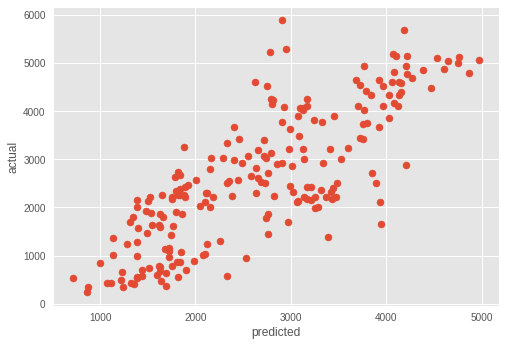

In [0]:
# I like it
plt.style.use('ggplot')

# Make prediction with test data
preds = models['gb'].predict(input_test)

# Plot predictions on x axis and actuals on y axis
plt.scatter(preds, target_test)

# Label axes and show graph
plt.xlabel('predicted')
plt.ylabel('actual')
plt.plot()

